# Figure 11

[Skip code and jump to the figure](#Show-the-figure)

----------------------------------

In [1]:
import warnings

warnings.filterwarnings("ignore")

In [2]:
# Scientific and datavis stack
import iris.cube
import matplotlib as mpl
import matplotlib.pyplot as plt
import numpy as np
from matplotlib import ticker

In [3]:
# My packages and local scripts
from aeolus.calc import time_mean
from aeolus.const import init_const
from aeolus.coord import isel
from aeolus.core import AtmoSim
from aeolus.io import load_data, load_vert_lev
from aeolus.model import um
from aeolus.plot import add_custom_legend, subplot_label_generator, tex2cf_units
from aeolus.region import Region
from aeolus.synthobs import (
    calc_stellar_flux,
    calc_transmission_spectrum,
    read_normalized_stellar_flux,
    read_spectral_bands,
)
from pouch.path import lsdir
from pouch.plot import (
    KW_AUX_TTL,
    KW_MAIN_TTL,
    KW_SBPLT_LABEL,
    KW_ZERO_LINE,
    figsave,
    use_style,
)

In [4]:
import mypaths
from commons import GLM_MODEL_TIMESTEP, GLM_SUITE_ID, NIGHTSIDE, SIM_LABELS

Apply custom matplotlib style sheet.

In [5]:
use_style()

## Load model data from the two key experiments

In [6]:
sim_label_a, sim_label_b = SIM_LABELS.keys()

Define paths to input data and results.

In [7]:
# SELECTED_SIM = {k: v for k, v in {**SIM}.items() if k in ["hab1", "hab2"]}
img_prefix = f"{GLM_SUITE_ID}_synthobs"
inp_dir = mypaths.sadir / f"{GLM_SUITE_ID}_synthobs"
time_prof = "synthobs"
plotdir = mypaths.plotdir / img_prefix

Define various options for spectral files (only one is actually used).

In [8]:
RAD_OPT_LABELS = {
    "dsa_mcica_hybrid": {
        "title": "DSA hybrid; MCICA",
        "kw_plt": {"color": "C1"},
        "spectral_file_sw": mypaths.home
        / "spectral"
        / "trappist1"
        / "dsa_hybrid"
        / "sp_sw_280_dsa_trappist1",
    },
    "dsa_scaled_cloud_lowres": {
        "title": "DSA low-res; scaling factor",
        "kw_plt": {"color": "C2"},
        "spectral_file_sw": mypaths.home
        / "spectral"
        / "trappist1"
        / "dsa"
        / "sp_sw_21_dsa_trappist1",
    },
    "dsa_scaled_cloud_highres": {
        "title": "DSA high-res; scaling factor",
        "kw_plt": {"color": "C3"},
        "spectral_file_sw": mypaths.home
        / "spectral"
        / "trappist1"
        / "dsa_hr"
        / "sp_sw_280_dsa_trappist1",
    },
}

In [9]:
rad_opt_label = "dsa_mcica_hybrid"

Load processed data

In [10]:
runs = {}
for sim_label, sim_prop in SIM_LABELS.items():
    planet = sim_prop["planet"]
    const = init_const(planet, directory=mypaths.constdir)
    cl = load_data(
        files=inp_dir / f"{GLM_SUITE_ID}_{sim_label}_{time_prof}.nc",
    )
    runs[sim_label] = AtmoSim(
        cl,
        name=sim_label,
        planet=sim_prop["planet"],
        const_dir=mypaths.constdir,
        model=um,
        vert_coord=None,
    )
    runs[sim_label].theta_levels = iris.cube.Cube(
        data=load_vert_lev(mypaths.home / "vert" / "vertlevs_L38_29t_9s_80km"),
        units="m",
        long_name="level_height",
    )
    runs[sim_label].spectral_file_sw = RAD_OPT_LABELS[rad_opt_label]["spectral_file_sw"]

## Process variables before plotting

Define rules for the variables to plot.

In [11]:
DIAGS = {
    "cloudy": {
        "cube": lambda AS: AS._cubes.extract_cube("m01s01i555"),
        "title": "Cloudy",
        "tex_units": "$W$ $m^{-2}$",
        "kw_plt": {"linestyle": "-", "alpha": 1}
        # "kw_plt": {"linestyle": "-", "lw": 4, "alpha":0.25},
    },
    "clear": {
        "cube": lambda AS: AS._cubes.extract_cube("m01s01i556"),
        "title": "Clear-sky",
        "tex_units": "$W$ $m^{-2}$",
        "kw_plt": {"linestyle": "--", "dash_capstyle": "round"},
    },
}

Store final results in a dictionary.

In [12]:
RESULTS = {}
for sim_label in SIM_LABELS.keys():
    the_run = runs[sim_label]
    planet_top_of_atmosphere = the_run.const.radius + the_run.theta_levels[-1]
    stellar_constant_at_1_au = (
        the_run.const.solar_constant
        * (the_run.const.semi_major_axis / iris.cube.Cube(data=1, units="au")) ** 2
    )
    RESULTS[sim_label] = {}
    for (vrbl_key, vrbl_dict) in DIAGS.items():
        cube = vrbl_dict["cube"](the_run)
        cube.units = tex2cf_units(vrbl_dict["tex_units"])
        # cube.convert_units(tex2cf_units(vrbl_dict["tex_units"]))
        RESULTS[sim_label][vrbl_key] = (
            calc_transmission_spectrum(
                cube,
                the_run.spectral_file_sw,
                stellar_constant_at_1_au,
                the_run.const.stellar_radius,
                planet_top_of_atmosphere,
                model=the_run.model,
            )
            ** 2
        )

## Create the figure

In [13]:
imgname = f"{img_prefix}__{'_'.join(SIM_LABELS.keys())}__{'_'.join(DIAGS.keys())}"
kw_plt_common = {"lw": 1.0}

fig = plt.figure(figsize=(16, 9))
axd = fig.subplot_mosaic(
    [[i] for i in [*DIAGS.keys(), "diff"]], gridspec_kw={"hspace": 0.5}
)
iletters = subplot_label_generator()
for ax in axd.values():
    ax.set_title(f"{next(iletters)}", **KW_SBPLT_LABEL)
    if ax.get_subplotspec().is_last_row():
        ax.set_xlabel("Wavelength [$\mu$m]")
    if ax.get_subplotspec().is_first_col():
        ax.set_ylabel(r"($R_p/R_s)^2$ [ppm]")
        # ax.set_ylabel(r"($R_p/R_s)^2$ $\times 10^{6}$")
        # ax.set_ylabel("Transmission\ndepth [ppm]")

    ax.set_xscale("log")
    xticks = np.concatenate([[0.6, 1, 1.5], np.arange(2, 10, 1), np.arange(10, 22, 2)])
    ax.xaxis.set_major_locator(ticker.FixedLocator(xticks))
    ax.xaxis.set_major_formatter(
        ticker.FuncFormatter(
            lambda x, pos: f"{int(x):d}" if int(x) == x else f"{x:.1f}"
        )
    )
    ax.set_xlim(xticks.min(), xticks.max())

for (vrbl_key, vrbl_dict) in DIAGS.items():
    for sim_label, sim_prop in SIM_LABELS.items():
        cube_mean = time_mean(RESULTS[sim_label][vrbl_key])
        cube_std = (RESULTS[sim_label][vrbl_key]).collapsed(um.t, iris.analysis.STD_DEV)
        x = cube_mean.coord("spectral_band_centres")
        axd[vrbl_key].fill_between(
            x.points * 1e6,
            (cube_mean - cube_std).data * 1e6,
            (cube_mean + cube_std).data * 1e6,
            alpha=0.5,
            **sim_prop["kw_plt"],
        )
        axd[vrbl_key].plot(
            x.points * 1e6,
            cube_mean.data * 1e6,
            **kw_plt_common,
            **sim_prop["kw_plt"],
            **vrbl_dict["kw_plt"],
        )

# Difference
for (vrbl_key, vrbl_dict) in DIAGS.items():
    cube_diff = RESULTS[sim_label_b][vrbl_key] - RESULTS[sim_label_a][vrbl_key]
    cube_mean = time_mean(cube_diff)
    cube_std = cube_diff.collapsed(um.t, iris.analysis.STD_DEV)

    x = cube_diff.coord("spectral_band_centres")
    axd["diff"].fill_between(
        x.points * 1e6,
        (cube_mean - cube_std).data * 1e6,
        (cube_mean + cube_std).data * 1e6,
        alpha=0.5,
        color="k",
        linewidth=0,
    )
    axd["diff"].plot(
        x.points * 1e6,
        cube_mean.data * 1e6,
        color="k",
        **kw_plt_common,
        **vrbl_dict["kw_plt"],
    )
    axd["diff"].axhline(0, **KW_ZERO_LINE)


add_custom_legend(
    fig,
    {
        **{v["title"]: {**kw_plt_common, **v["kw_plt"]} for v in SIM_LABELS.values()},
        **{
            v["title"]: {**kw_plt_common, "color": "tab:grey", **v["kw_plt"]}
            for v in DIAGS.values()
        },
    },
    loc="upper center",
    frameon=False,
    ncol=2,
    fontsize="medium",
    title="Transmission spectra for TRAPPIST-1e",
)

axd["cloudy"].set_title(
    "Cloudy",
    loc="right",
    size="medium",
)
axd["clear"].set_title(
    "Clear-sky",
    loc="right",
    size="medium",
)
axd["diff"].set_title(
    "Differences",
    loc="right",
    size="medium",
)
plt.close()

# Show the figure

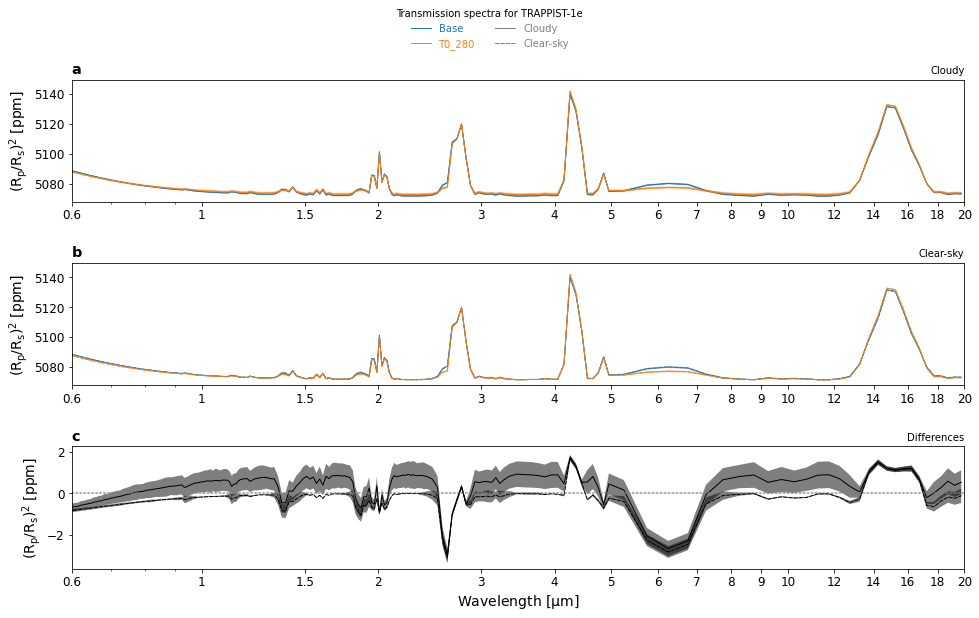

In [14]:
fig

* **Simulated transmission spectra for the (blue) SJ and (orange) DJ cases.**
* **The transmission spectra are calculated using fluxes (a) with and (b) without the effect of clouds included.**
* **Panel c shows the difference, SJ minus DJ, for (solid lines) cloudy and (dashed lines) clear-sky calculations.**

In [15]:
figsave(fig, plotdir / imgname)

Saved to ../plots/ch111_synthobs/ch111_synthobs__base_sens-t280k__cloudy_clear.png


---

## Extra

### Atmospheric depth

In [16]:
vrbl_key = "cloudy"

In [17]:
cube = RESULTS[sim_label_a][vrbl_key] ** 2 * 1e6
x = cube.coord("spectral_band_centres").points * 1e6

In [18]:
cube_mean = time_mean(cube)
cube_std = cube.collapsed(um.t, iris.analysis.STD_DEV)

In [19]:
delta_sqrt = isel(RESULTS[sim_label][vrbl_key], um.t, -1)

In [20]:
atm_depth = delta_sqrt * the_run.const.stellar_radius - the_run.const.radius

(0.5, 5.5)

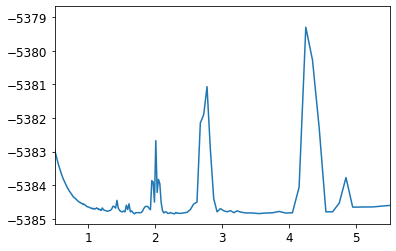

In [21]:
ax = plt.axes()
# ax.set_xscale("log")
ax.plot(x, atm_depth.data / 1e3)
ax.set_xlim(0.5, 5.5)

### Stellar spectrum

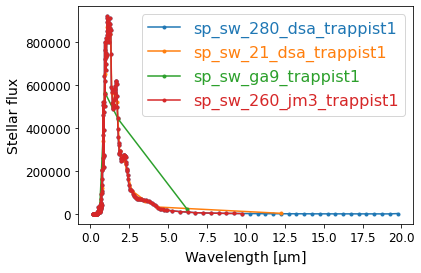

In [22]:
spectral_files = [
    mypaths.home / "spectral" / "trappist1" / "dsa_hr" / "sp_sw_280_dsa_trappist1",
    mypaths.home / "spectral" / "trappist1" / "dsa" / "sp_sw_21_dsa_trappist1",
    mypaths.home / "spectral" / "trappist1" / "ga9" / "sp_sw_ga9_trappist1",
    mypaths.home / "spectral" / "trappist1" / "ga9_ref" / "sp_sw_260_jm3_trappist1",
]

fig, ax = plt.subplots()
ax.set_xlabel("Wavelength [$\mu$m]")
ax.set_ylabel("Stellar flux")
for spectral_file in spectral_files:

    stellar_flux = read_normalized_stellar_flux(spectral_file)
    spectral_bands = read_spectral_bands(spectral_file)
    spectral_band_centres = 0.5 * (
        spectral_bands["lower_wavelength_limit"]
        + spectral_bands["upper_wavelength_limit"]
    )
    band_widths = (
        spectral_bands["upper_wavelength_limit"]
        - spectral_bands["lower_wavelength_limit"]
    )

    ax.plot(
        spectral_band_centres * 1e6,
        stellar_flux.data / band_widths,
        marker=".",
        label=spectral_file.name,
    )
ax.legend();

In [23]:
normalized_stellar_flux = read_normalized_stellar_flux(the_run.spectral_file_sw)

Text(0.0, 1.0, 'Spectral file: ga9_ref/sp_sw_280_dsa_trappist1')

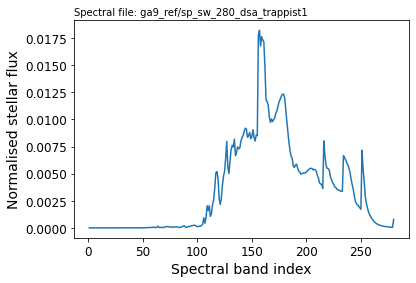

In [24]:
fig, ax = plt.subplots()
ax.plot(
    normalized_stellar_flux.coord("spectral_band_index").points,
    normalized_stellar_flux.data,
)
ax.set_xlabel("Spectral band index")
ax.set_ylabel("Normalised stellar flux")
ax.set_title(
    f"Spectral file: ga9_ref/{the_run.spectral_file_sw.name}", loc="left", size="medium"
)

# figsave(fig, plotdir / f"{spectral_file.name}__normalised_stellar_flux")

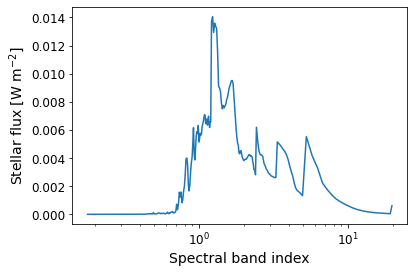

In [25]:
stellar_flux = calc_stellar_flux(the_run.spectral_file_sw, stellar_constant_at_1_au)

fig, ax = plt.subplots()
ax.plot(x, stellar_flux.data)
ax.set_xscale("log")
ax.set_xlabel("Spectral band index")
ax.set_ylabel("Stellar flux [W $m^{-2}$]");

### Scaled cloud vs MCICA

Saved to ../../plots/sa/ch111/ch111_synthobs/ch111_synthobs__grcs_llcs__hsw_llw_scaled_cloud__trans_cloudy_trans_clear__diffs.png


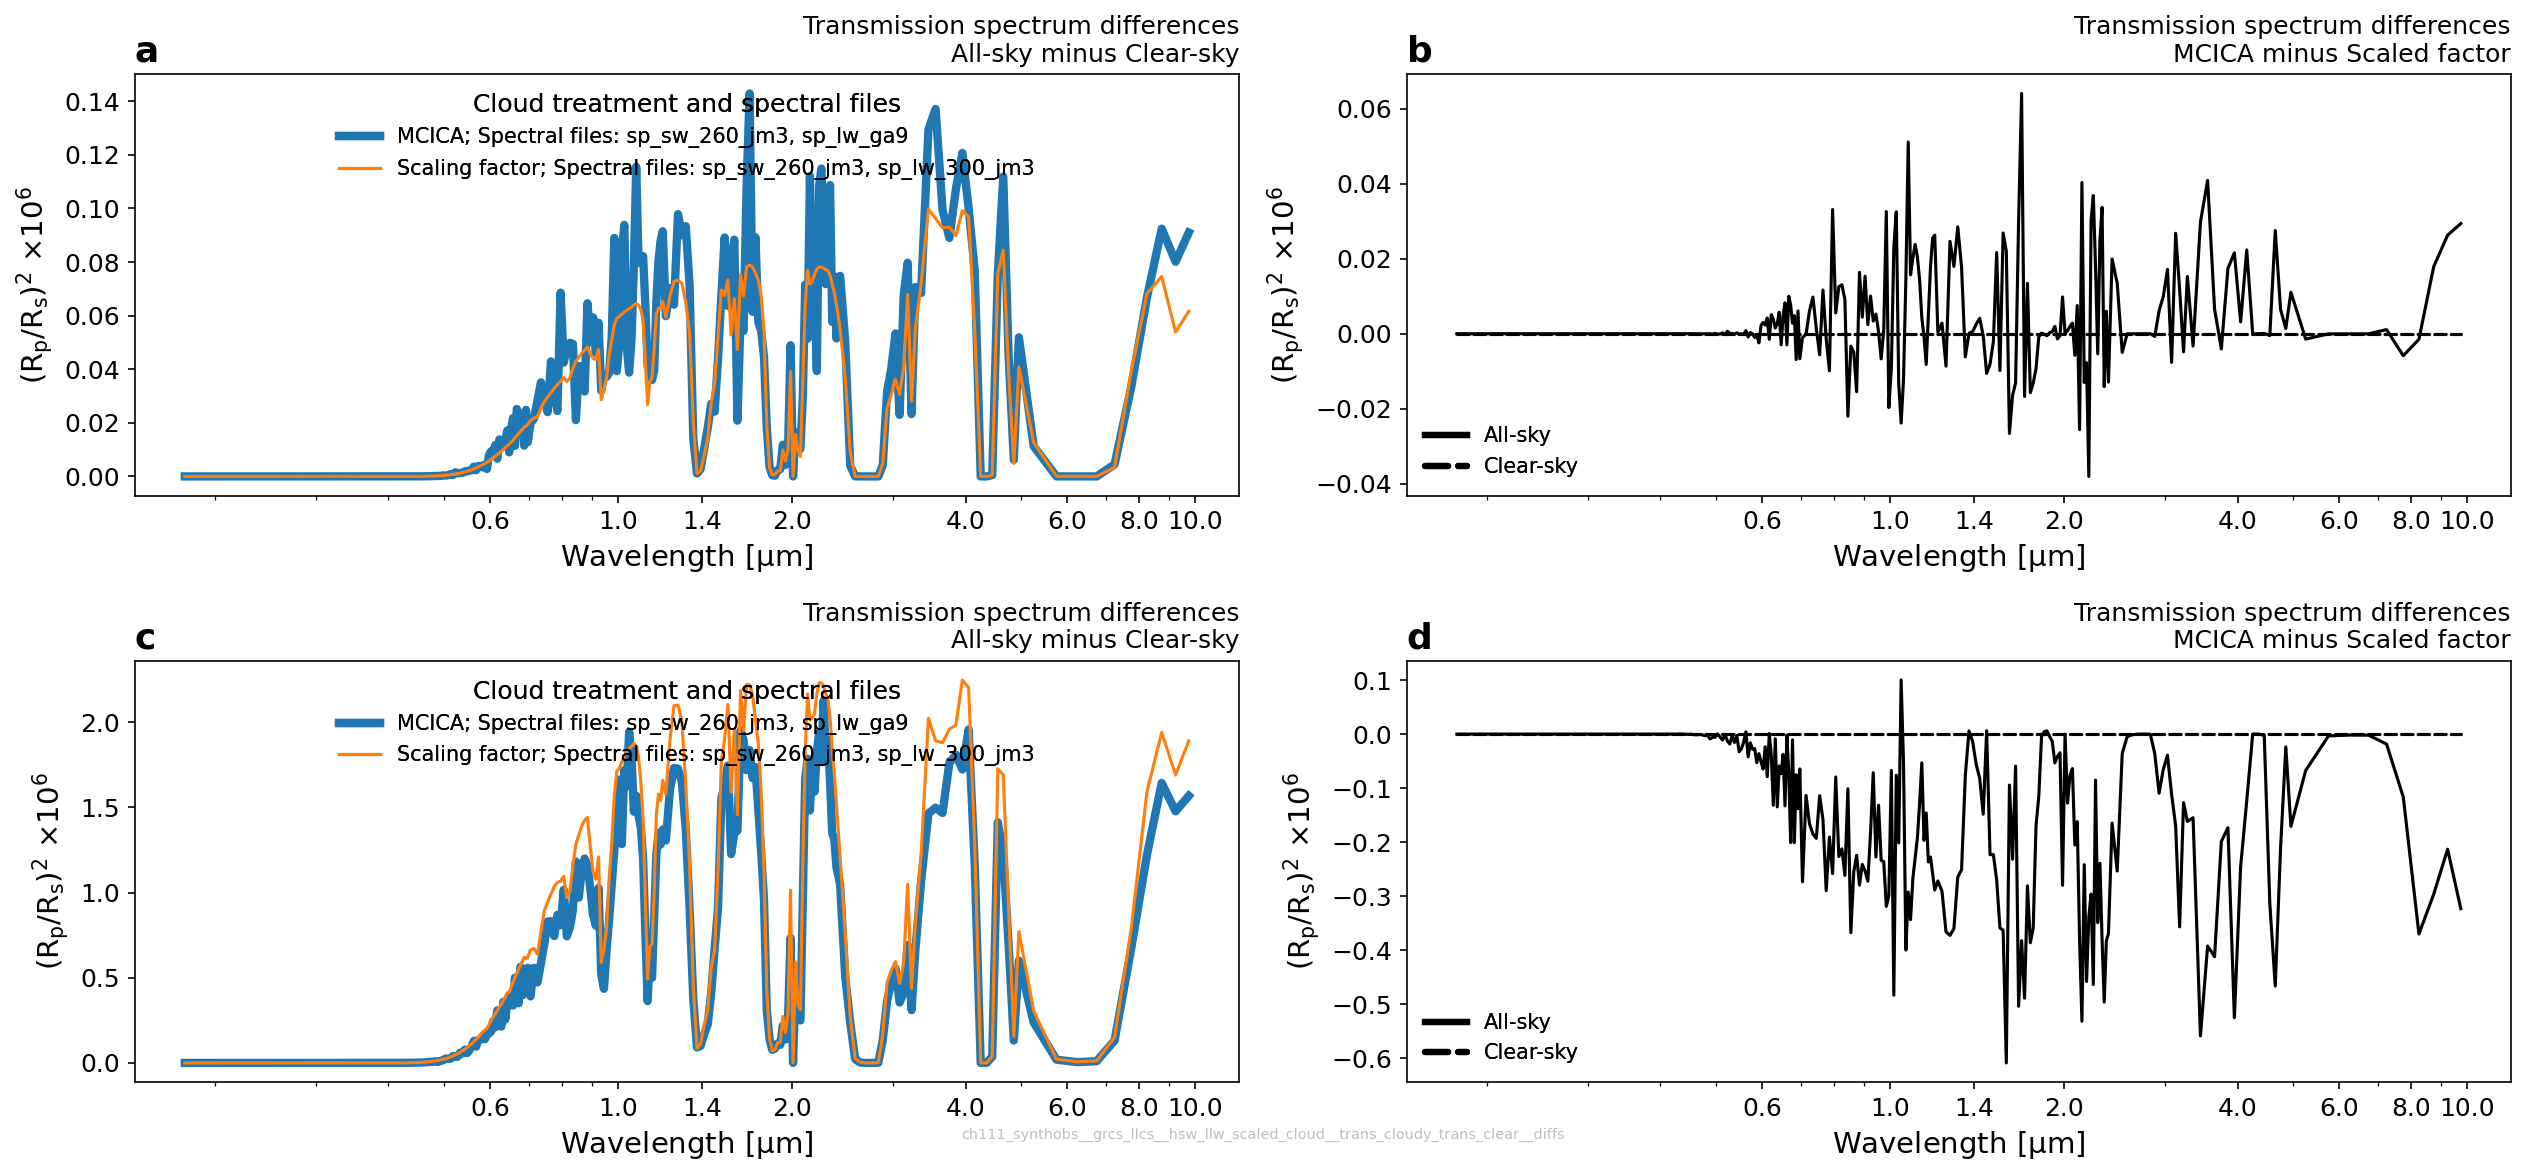

In [15]:
imgname = (
    f"{img_prefix}__{'_'.join(SUITE_LABELS.keys())}__"
    f"{'_'.join(OPT_LABELS.keys())}__{'_'.join(VRBL_PLOT.keys())}__diffs"
)
ncols = 2
nrows = len(SUITE_LABELS)
fig, axs = plt.subplots(
    ncols=ncols, nrows=nrows, figsize=(ncols * 8.5, nrows * 4), squeeze=False
)
iletters = subplot_label_generator()
for ax in axs.flat:
    ax.set_title(f"{next(iletters)}", **KW_SBPLT_LABEL)
    ax.set_xlabel("Wavelength [$\mu$m]")
    ax.set_ylabel(r"($R_p/R_s)^2$ $\times 10^{6}$")
    ax.set_xscale("log")
    xticks = np.concatenate(
        [
            [0.6, 1, 1.4],
            np.arange(2, 12, 2),
            # np.arange(12, 22, 2),
        ]
    )
    ax.set_xticks(xticks)
    ax.set_xticklabels(xticks)
    # ax.set_xlim(xticks.min(), xticks.max())

for suite_label, axrow in zip(SUITE_LABELS.keys(), axs):
    ax = axrow[0]
    ax.set_title(
        "Transmission spectrum differences\nAll-sky minus Clear-sky",
        loc="right",
        size="medium",
    )
    for opt_label, opt_prop in OPT_LABELS.items():
        sim_label = f"{suite_label}_{opt_label}"
        cube = (
            RESULTS[sim_label]["trans_cloudy"] ** 2
            - RESULTS[sim_label]["trans_clear"] ** 2
        ) * 1e6
        x = cube.coord("spectral_band_centres").points * 1e6
        ax.plot(
            x,
            cube.data,
            **opt_prop["kw_plt"],
        )
    add_custom_legend(
        ax,
        {v["title"]: {"linestyle": "-", **v["kw_plt"]} for v in OPT_LABELS.values()},
        loc="upper center",
        # bbox_to_anchor=(0.5, 1.05),
        frameon=False,
        ncol=1,
        title="Cloud treatment and spectral files",
        fontsize="small",
    )

    ax = axrow[1]
    ax.set_title(
        "Transmission spectrum differences\nMCICA minus Scaled factor",
        loc="right",
        size="medium",
    )
    for i, (vrbl_key, vrbl_dict) in enumerate(VRBL_PLOT.items()):
        cube = (
            RESULTS[f"{suite_label}_hsw_llw"][vrbl_key] ** 2
            - RESULTS[f"{suite_label}_scaled_cloud"][vrbl_key] ** 2
        ) * 1e6
        x = cube.coord("spectral_band_centres").points * 1e6
        ax.plot(
            x,
            cube.data,
            color="k",
            **vrbl_dict["kw_plt"],
            # marker="o",
            # ms=3,
        )
    add_custom_legend(
        ax,
        {
            v["title"]: {"color": "k", "linewidth": 3, **v["kw_plt"]}
            for v in VRBL_PLOT.values()
        },
        loc="lower left",
        frameon=False,
        ncol=1,
        fontsize="small",
    )

fig.tight_layout()
figsave(fig, plotdir / imgname)